In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import os.path as op
import json
from pathlib import Path
from skimage import io
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report



In [2]:
# Global Variables
META_DATA_PATH="../Data/instagram_data.csv"
IMAGE_SIZE = (600, 600)
IMAGE_SHAPE = (600, 600, 3)
x_columns = ["no_of_comments", "t", "follower_count_at_t", "image_path"]
y_columns = ["likes_level"]
TEST_RATIO = 0.2
# 0.23 * 0.8 is nearing to 0.2, train : test: validate is about 6: 2: 2
VALIDATE_RATIO = 0.23 
RANDOM_STATE = 0

In [3]:
def remove_outliers(df): 
    data_no_outliers = df.copy()
    factor = 5
    for c in df.select_dtypes(include=['number']).columns:
        Q1 = data_no_outliers[c].quantile(0.25)
        Q3 = data_no_outliers[c].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        data_no_outliers = data_no_outliers[(data_no_outliers[c] >= lower_bound) & (data_no_outliers[c] <= upper_bound)]
    return data_no_outliers

def plot_roc(data_y, data_y_predict, model, title):
    fig, axes = plt.subplots(figsize = (12, 9))
    axes.set_title(f"{title} ROC curve")
    for i, class_ in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(data_y, data_y_predict, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        actions_dict = {0: "Low", 1: "Medium", 2: "High"}
        curclass = actions_dict[class_]
        axes.plot(fpr, tpr, label=f"Class: {curclass}; ROC Curve Area: {round(roc_auc, 3)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("FPR")
    axes.set_ylabel("TPR")
    axes.legend()
    plt.show()
    
def calculate_confusion_matrix(y_data, y_data_pred, title):
    cm = confusion_matrix(y_data.to_numpy(dtype=float), y_data_pred)
    print(f"{title} Confusion Matrix")
    print ("{:>5} {:>5} {:>5} {:>5}".format(' ','0','1','2'))
    for i in range(0, len(cm)):
        print ("{:>5} {:>5} {:>5} {:>5}".format(i, cm[i][0], cm[i][1], cm[i][2]))
    
    

In [4]:
meta_df=pd.read_csv(META_DATA_PATH)

data_no_outliers = remove_outliers(meta_df).reset_index(drop = True)


likes_level = []

sorted_likes = data_no_outliers["likes"].sort_values().reset_index(drop = True)
level_0_bound = sorted_likes[int(len(sorted_likes) * 0.33)]
level_1_bound = sorted_likes[int(len(sorted_likes) * 0.67)]

for i in range(0, len(data_no_outliers)):
    if data_no_outliers["likes"][i] <= level_0_bound:
        likes_level.append(0)
    elif data_no_outliers["likes"][i] <= level_1_bound:
        likes_level.append(1)
    else:
        likes_level.append(2)

data_no_outliers["likes_level"] = likes_level

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_no_outliers[x_columns], 
                                                    data_no_outliers[y_columns], 
                                                    test_size = TEST_RATIO, 
                                                    random_state = RANDOM_STATE)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size = VALIDATE_RATIO, 
                                                    random_state = RANDOM_STATE)


In [6]:
test_images = []
validate_images = []
train_images = []

for i in tqdm(range(len(x_train))):
    dir = meta_df["image_path"][i]
    file = Path(dir)
    img = io.imread(file)
    resized_image = cv2.resize(img, IMAGE_SIZE)
    train_images.append(resized_image)
    
for i in tqdm(range(len(x_test))):
    dir = meta_df["image_path"][i]
    file = Path(dir)
    img = io.imread(file)
    resized_image = cv2.resize(img, IMAGE_SIZE)
    test_images.append(resized_image)
    
for i in tqdm(range(len(x_validate))):
    dir = meta_df["image_path"][i]
    file = Path(dir)
    img = io.imread(file)
    resized_image = cv2.resize(img, IMAGE_SIZE)
    validate_images.append(resized_image)

print(f"Test: {len(x_test)}  {len(test_images)}")
print(f"Train: {len(x_train)}  {len(train_images)}")
print(f"Validate: {len(x_validate)}  {len(validate_images)}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 658/658 [00:08<00:00, 77.02it/s]

Test: 715  715
Train: 2202  2202
Validate: 658  658


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import tensorflow_addons as tfa

/Users/nickchu/venv-metal/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
model = Sequential()
tqdm_callback = tfa.callbacks.TQDMProgressBar()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output neurons for 3 like levels
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

2023-12-27 10:40:21.657272: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2023-12-27 10:40:21.657291: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2023-12-27 10:40:21.657294: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2023-12-27 10:40:21.657346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 10:40:21.657595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/nickchu/venv-metal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io

In [9]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience = 10, 
    restore_best_weights = True
)

history = model.fit(
    np.array(train_images),  
    y_train,
    epochs=30,
    batch_size = 32,
    validation_data = (np.array(validate_images), y_validate),
    callbacks=[early_stopping]
)

Epoch 1/30


2023-12-27 10:40:24.107023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 24s 324ms/step - loss: 1454.6887 - accuracy: 0.3397 - val_loss: 653.9526 - val_accuracy: 0.3617
Epoch 2/30
69/69 [==============================] - 21s 296ms/step - loss: 221.3317 - accuracy: 0.3333 - val_loss: 83.8715 - val_accuracy: 0.3207
Epoch 3/30
69/69 [==============================] - 20s 292ms/step - loss: 94.6768 - accuracy: 0.3524 - val_loss: 251.9924 - val_accuracy: 0.3435
Epoch 4/30
69/69 [==============================] - 20s 290ms/step - loss: 106.1087 - accuracy: 0.3588 - val_loss: 101.2299 - val_accuracy: 0.3070
Epoch 5/30
69/69 [==============================] - 20s 291ms/step - loss: 252.5619 - accuracy: 0.3583 - val_loss: 256.8158 - val_accuracy: 0.3465
Epoch 6/30
69/69 [==============================] - 20s 285ms/step - loss: 84.6908 - accuracy: 0.3547 - val_loss: 58.1036 - val_accuracy: 0.3343
Epoch 7/30
69/69 [==============================] - 20s 283ms/step - loss: 47.8521 - accuracy: 0.3647 - val_loss: 55.4242 - val_accu

In [10]:
# y_pred_prob = model.predict(np.array(test_images))
# y_pred = np.argmax(y_pred_prob, axis=1)


23/23 [==============================] - 1s 57ms/step
Accuracy: 0.34
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.35      0.44      0.39       241
           1       0.35      0.27      0.30       252
           2       0.33      0.33      0.33       222

    accuracy                           0.34       715
   macro avg       0.34      0.34      0.34       715
weighted avg       0.34      0.34      0.34       715

 
--------------------------------------------------
 
Neural Network Confusion Matrix
          0     1     2
    0   105    63    73
    1   106    67    79
    2    86    62    74
 
--------------------------------------------------
 


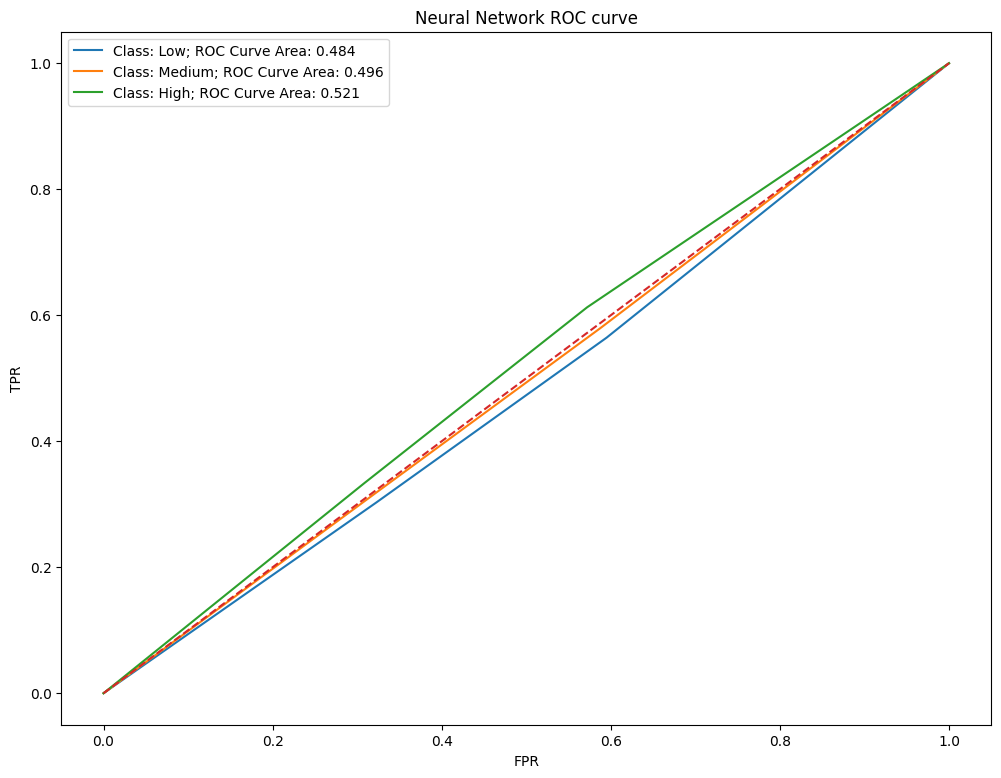

In [11]:
def plot_roc(data_y, data_y_predict, model, title):
    fig, axes = plt.subplots(figsize = (12, 9))
    axes.set_title(f"{title} ROC curve")
    for class_ in range(3):
        fpr, tpr, thresholds = roc_curve(data_y, data_y_predict, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        actions_dict = {0: "Low", 1: "Medium", 2: "High"}
        curclass = actions_dict[class_]
        axes.plot(fpr, tpr, label=f"Class: {curclass}; ROC Curve Area: {round(roc_auc, 3)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("FPR")
    axes.set_ylabel("TPR")
    axes.legend()
    plt.show()
    
def calculate_confusion_matrix(y_data, y_data_pred, title):
    cm = confusion_matrix(y_data.to_numpy(dtype=float), y_data_pred)
    print(f"{title} Confusion Matrix")
    print ("{:>5} {:>5} {:>5} {:>5}".format(' ','0','1','2'))
    for i in range(0, len(cm)):
        print ("{:>5} {:>5} {:>5} {:>5}".format(i, cm[i][0], cm[i][1], cm[i][2]))
    
    
def print_separation():
    print(" ")
    print("--------------------------------------------------")
    print(" ")
    
def create_report(model, title):
    y_pred_prob = model.predict(np.array(test_images))
    y_pred = np.argmax(y_pred_prob, axis=1)
    # y_pred_prob = model.predict_proba(np.array(test_images))
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print_separation()
    print(report)
    print_separation()
    calculate_confusion_matrix(y_test, y_pred, title)
    print_separation()
    plot_roc(y_test, y_pred, model, title)

create_report(model, "Neural Network")

